In [3]:
import json
import os
import numpy as np
import pandas as pd
from scipy.stats import t
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from collections import defaultdict


def load_sample(file_path):
        data = np.load(file_path, allow_pickle=False)
        return data


def read_traces(log_path):
    '''
    read the trace files and extract variable names
    data = [ [event, timestamp], [], [],......,[] ]
    '''
    with open(log_path, 'r') as f:
        data = json.load(f)
    return data

def calculate_confidence_interval(data, confidence=0.95):
    '''
    calculate the confidence interval of the data
    data: a list of execution intervals -> [1,2,3,4,5,6,7,8,9,10]
    '''
    n = len(data)
    m = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    start = m - h
    end = m + h
    return start, end

def get_uniquevar(raw_trace):
    ''' 
    convert the v2.2 trace into list of unique variables
    raw_trace = data from read_traces, list( (var, ts),(var, ts),(var, ts),.... )
    return:
        unique_var = list(var1,var2,...) ## list of strings
    '''
    unique_var = []
    for rt in raw_trace:
        [var, timestamp] = rt
        # print([var, timestamp])
        if var not in unique_var:
            unique_var += [var]
            # print(rt)
    return unique_var


def generate_map(unique_events):
    '''
    unique_events -> list of all the variables in the code (unique, and in order of logging)
    return:
        event_map -> takes the variable name and gives corresponding event number
        event_remap -> takes event number and gives associated variable name
    '''
    event_map = dict()
    event_remap = dict()
    for i in range(len(unique_events)):
        event_remap[i+1] = unique_events[i]
        event_map[unique_events[i]] = i+1

    return(event_map, event_remap)


    

In [4]:
############ configuration ################
############################################

code = 'theft_protection'       ### application (code)
behaviour = 'faulty_data'            ### normal, faulty_data
thread_typ = 'single'           ### single, multi
version = 2.2                     ### format of data collection
sub_len = 50

base_dir = '../data-subtraces' ### can be replaced with 'csv', 'exe_plot', 'histogram'
normal_path = base_dir+f'/version_{version}/{behaviour}/subtraces/{sub_len}/normal'
anomalies_path = base_dir+f'/version_{version}/{behaviour}/subtraces/{sub_len}/anomalies'
print(normal_path, anomalies_path)


../data-subtraces/version_2.2/faulty_data/subtraces/50/normal ../data-subtraces/version_2.2/faulty_data/subtraces/50/anomalies


In [5]:
############ Get the Data ############
'''
unlike thresholding and state machine, we work with subtraces, where only sequence with correct behaviour is considered. 
This is due to the fact that, we dont need to calculate and features which needs larger traces. Also, dividing the traces in subtraces allows us to remove the anomalies in the normal trace. 
'''

normal_files = os.listdir(normal_path)
if '.DS_Store' in normal_files:
    normal_files.remove('.DS_Store')

anomalies_files = os.listdir(anomalies_path)
if '.DS_Store' in anomalies_files:
    anomalies_files.remove('.DS_Store')

normal_files = [os.path.join(normal_path, x) for x in normal_files]
anomalies_files = [os.path.join(anomalies_path, x) for x in anomalies_files]

normal_labels = [0]*len(normal_files)
anomalies_labels = [1]*len(anomalies_files)

# #### split the normal data in 80:20 ratio
# X_train, X_test, y_train, y_test = train_test_split(normal_files, normal_labels, test_size=0.2, random_state=42)

# #### combine the train and test data
# X_test += anomalies_files
# y_test += anomalies_labels

# #### shuffle test files
# X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [6]:
normal_files

['../data-subtraces/version_2.2/faulty_data/subtraces/50/normal/trace2-bitflip_3850_3900.npy',
 '../data-subtraces/version_2.2/faulty_data/subtraces/50/normal/trace1-comm_8750_8800.npy',
 '../data-subtraces/version_2.2/faulty_data/subtraces/50/normal/trace1-comm_5600_5650.npy',
 '../data-subtraces/version_2.2/faulty_data/subtraces/50/normal/trace1-comm_8150_8200.npy',
 '../data-subtraces/version_2.2/faulty_data/subtraces/50/normal/trace2-bitflip_10500_10550.npy',
 '../data-subtraces/version_2.2/faulty_data/subtraces/50/normal/trace1-comm_5750_5800.npy',
 '../data-subtraces/version_2.2/faulty_data/subtraces/50/normal/trace1-comm_8600_8650.npy',
 '../data-subtraces/version_2.2/faulty_data/subtraces/50/normal/trace2-bitflip_8800_8850.npy',
 '../data-subtraces/version_2.2/faulty_data/subtraces/50/normal/trace3-sensor_9450_9500.npy',
 '../data-subtraces/version_2.2/faulty_data/subtraces/50/normal/trace2-bitflip_7050_7100.npy',
 '../data-subtraces/version_2.2/faulty_data/subtraces/50/normal/

### LSTM

In [1]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Convert subtraces into sequences
def create_sequences(subtraces, sequence_length):
    sequences = []
    for subtrace in subtraces:
        for i in range(len(subtrace) - sequence_length + 1):
            sequence = subtrace[i:i+sequence_length]
            sequences.append(sequence)
    return np.array(sequences)



In [104]:
# read subtraces
normal_subtraces = []    ### fromat -> [ [[var1, ts1], [var2, ts2] ], [[var1, ts1], [var2, ts2] ], [[var1, ts1], [var2, ts2] ],.... ]
for nf in normal_files:
    data = load_sample(nf)
    normal_subtraces += [data]

anomalies_subtraces = []
for af in anomalies_files:
    data = load_sample(af)
    anomalies_subtraces += [data]

### replace the variable names with event numbers based on var_list.npy
event_map, event_remap = generate_map(np.load('../../analysis scripts/var_list.npy', allow_pickle=True))
# print(event_map)

for i in range(len(normal_subtraces)):
    for j in range(len(normal_subtraces[i])):
        # print(i,j)
        # print(normal_subtraces[i][j])
        normal_subtraces[i][j][0] = event_map[normal_subtraces[i][j][0]]

for i in range(len(anomalies_subtraces)):
    for j in range(len(anomalies_subtraces[i])):
        anomalies_subtraces[i][j][0] = event_map[anomalies_subtraces[i][j][0]]

# Find the length of the longest sequence
max_len = max(len(seq) for seq in normal_subtraces)

# remove the sequences with length less than max_len
# normal_subtraces = [seq for seq in normal_subtraces if len(seq) == max_len]
# anomalies_subtraces = [seq for seq in anomalies_subtraces if len(seq) == max_len]

# Normalize the data separately for 'normal' and 'anomalies' subtraces
scaler_normal = MinMaxScaler(feature_range=(0, 1))
scaler_anomalies = MinMaxScaler(feature_range=(0, 1))

normal_subtraces_normalized = [None]*len(normal_subtraces)
for i in range(len(normal_subtraces)):
    normal_subtraces_normalized[i] = scaler_normal.fit_transform(normal_subtraces[i])

anomalies_subtraces_normalized = [None]*len(anomalies_subtraces)
for i in range(len(anomalies_subtraces)):
    anomalies_subtraces_normalized[i] = scaler_anomalies.fit_transform(anomalies_subtraces[i])


# Create sequences with a specified sequence length for 'normal' subtraces
sequence_length = 26  # Adjust based on your data

# Create sequences for 'normal' subtraces
sequences_normal = create_sequences(normal_subtraces_normalized, sequence_length)

# Split 'normal' sequences into training and testing sets
train_size_normal = int(len(sequences_normal) * 0.8)
train_normal, test_normal = sequences_normal[0:train_size_normal], sequences_normal[train_size_normal:]

# generate ground truth for test_normal
test_normal_labels = np.zeros(len(test_normal))

# Create sequences for 'anomalies' subtraces
sequences_anomalies = create_sequences(anomalies_subtraces_normalized, sequence_length)

# Split 'anomalies' sequences into testing set (no training on anomalies)
test_anomalies = sequences_anomalies

# generate ground truth for test_anomalies
test_anomalies_labels = np.ones(len(test_anomalies))

# Prepare input and output data for the LSTM model
X_train, y_train = train_normal[:, :-1], train_normal[:, -1]

# Concatenate 'normal' and 'anomalies' testing sets
X_test = np.concatenate((test_normal[:, :-1], test_anomalies[:, :-1]), axis=0)
y_test = np.concatenate((test_normal[:, -1], test_anomalies[:, -1]), axis=0)

# Concatenate 'normal' and 'anomalies' ground truth
y_test_labels = np.concatenate((test_normal_labels, test_anomalies_labels), axis=0)


# Shuffle the training set
shuffle_indices_train = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_indices_train], y_train[shuffle_indices_train]

# Shuffle the testing set
shuffle_indices_test = np.random.permutation(len(X_test))
X_test, y_test = X_test[shuffle_indices_test], y_test[shuffle_indices_test]
y_test_labels = y_test_labels[shuffle_indices_test]

# # Reshape input data to be 3D [samples, timesteps, features] | Redundnat in our case
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))





### Training

In [105]:
######## Train model ############

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))  # Adjust the number of units based on your data
model.add(Dense(X_train.shape[2]))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on 'normal' subtraces
model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=2)

Epoch 1/40
312/312 - 4s - loss: 0.0414 - 4s/epoch - 14ms/step
Epoch 2/40
312/312 - 3s - loss: 0.0244 - 3s/epoch - 11ms/step
Epoch 3/40
312/312 - 4s - loss: 0.0120 - 4s/epoch - 12ms/step
Epoch 4/40
312/312 - 4s - loss: 0.0085 - 4s/epoch - 11ms/step
Epoch 5/40
312/312 - 4s - loss: 0.0057 - 4s/epoch - 11ms/step
Epoch 6/40
312/312 - 4s - loss: 0.0032 - 4s/epoch - 11ms/step
Epoch 7/40
312/312 - 4s - loss: 0.0023 - 4s/epoch - 11ms/step
Epoch 8/40
312/312 - 4s - loss: 0.0019 - 4s/epoch - 11ms/step
Epoch 9/40
312/312 - 4s - loss: 0.0019 - 4s/epoch - 11ms/step
Epoch 10/40
312/312 - 4s - loss: 0.0019 - 4s/epoch - 12ms/step
Epoch 11/40
312/312 - 4s - loss: 0.0018 - 4s/epoch - 11ms/step
Epoch 12/40
312/312 - 4s - loss: 0.0016 - 4s/epoch - 11ms/step
Epoch 13/40
312/312 - 4s - loss: 0.0016 - 4s/epoch - 11ms/step
Epoch 14/40
312/312 - 4s - loss: 0.0016 - 4s/epoch - 11ms/step
Epoch 15/40
312/312 - 4s - loss: 0.0015 - 4s/epoch - 11ms/step
Epoch 16/40
312/312 - 4s - loss: 0.0015 - 4s/epoch - 12ms/step
E

In [101]:
len(X_test)

6288

### Testing

In [109]:
# ### make prediction on X_test files individually
# predictions = []
# for i in range(len(X_test)):
#     predictions += [model.predict(X_test[i].reshape(1, X_test[i].shape[0], X_test[i].shape[1]))]

# Make predictions on 'anomalies' subtraces
anomalies_predictions = model.predict(X_test)
# print("Anomalies Predictions:", anomalies_predictions)
print("Anomalies Predictions Shape:", anomalies_predictions.shape)

# Calculate reconstruction error for each prediction
mse_anomalies = np.mean(np.square(y_test - anomalies_predictions), axis=1)
print(f"Mean Squared Errors on Anomalies: {mse_anomalies}")

# Set a threshold for anomaly detection based on the reconstruction error
threshold = 0.0012  # Adjust based on your data
# anomalies_detected = np.where(mse_anomalies > threshold)[0]
anomalies_detected = np.where(mse_anomalies > threshold, 1, 0)
print("Anomalies Detected Indices:", anomalies_detected)

197/197 [==============================] - 1s 4ms/step
Anomalies Predictions Shape: (6288, 2)
Mean Squared Errors on Anomalies: [2.58022106e-03 6.90259632e-02 1.02025698e-04 ... 1.06007118e-03
 1.53383967e-04 2.39368334e-05]
Anomalies Detected Indices: [1 1 0 ... 0 0 0]


In [107]:
mse_anomalies

array([2.58022106e-03, 6.90259632e-02, 1.02025698e-04, ...,
       1.06007118e-03, 1.53383967e-04, 2.39368334e-05])

#### Evaluation

_Classify Instances:_

- The model's predictions are converted to binary labels (0 for normal, 1 for anomaly) based on the specified threshold.

_Classification Report:_

- The classification_report function from scikit-learn is used to generate precision, recall, and F1-score for both classes (normal and anomaly).

_ROC AUC Score:_

- The ROC AUC score is calculated using the roc_auc_score function.

_Plot ROC Curve:_

- The ROC curve is plotted using the roc_curve function and visualized using Matplotlib.


Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.95      0.78      2492
         1.0       0.96      0.68      0.80      3796

    accuracy                           0.79      6288
   macro avg       0.81      0.82      0.79      6288
weighted avg       0.84      0.79      0.79      6288

ROC AUC Score: 0.8177423815218182


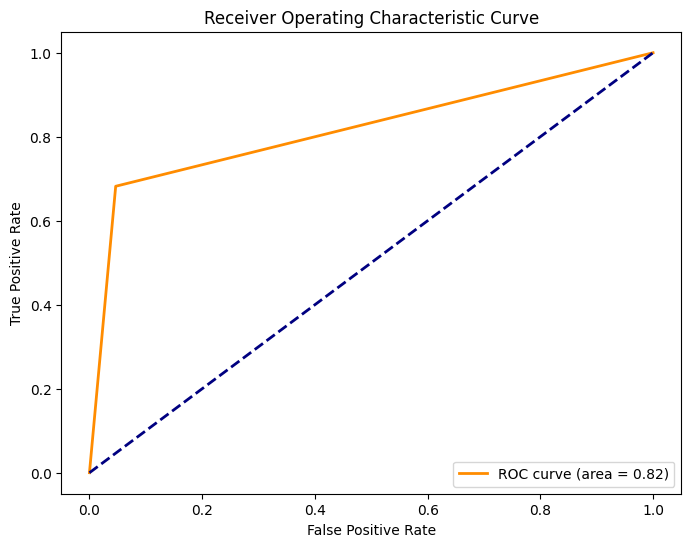

In [113]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

predictions = anomalies_detected
# predictions = np.where(mse_anomalies > threshold, 1, 0)
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test_labels, predictions))

# Calculate and print the ROC AUC score
roc_auc = roc_auc_score(y_test_labels, predictions)
print(f"ROC AUC Score: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_labels, predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

### Vizualize on Faulty data Trace